In [1]:
# HIDDEN

from datascience import *
import numpy as np

import matplotlib
matplotlib.use('Agg', warn=False)
%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

## Using the Bootstrap Method to Test Hypotheses

We have used random permutations to see whether two samples are drawn from the same underlying distribution. The bootstrap method can also be used in such statistical tests of hypotheses. 

The examples in this section are based on data on a random sample of 1,174 pairs of mothers and their newborn infants. The table ``baby`` contains the data. Each row represents a mother-baby pair. The variables are:
- the baby's birth weight in ounces
- the number of gestational days
- the mother's age in completed years
- the mother's height in inches
- the mother's pregnancy weight in pounds
- whether or not the mother was a smoker

In [2]:
baby = Table.read_table('baby.csv')
baby

Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
120,284,27,62,100,False
113,282,33,64,135,False
128,279,28,64,115,True
108,282,23,67,125,True
136,286,25,62,93,False
138,244,33,62,178,False
132,245,23,65,140,False
120,289,25,62,125,False
143,299,30,66,136,True
140,351,27,68,120,False


Suppose we want to compare the mothers who smoke and the mothers who are non-smokers. Do they differ in any way other than smoking? A key variable of interest is the birth weight of their babies. To study this variable, we begin by noting that there are 715 non-smokers among the women in the sample, and 459 smokers.

In [3]:
baby.group('Maternal Smoker')

Maternal Smoker,count
False,715
True,459


The first histogram below displays the distribution of birth weights of the babies of the non-smokers in the sample. The second displays the birth weights of the babies of the smokers.

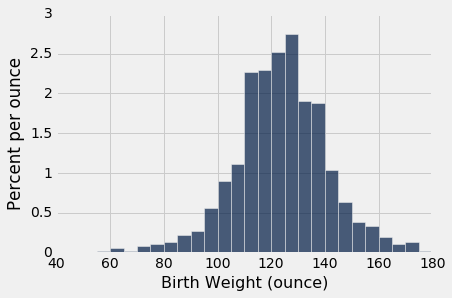

In [4]:
baby.where('Maternal Smoker', False).hist('Birth Weight', bins=np.arange(40, 181, 5), unit='ounce')

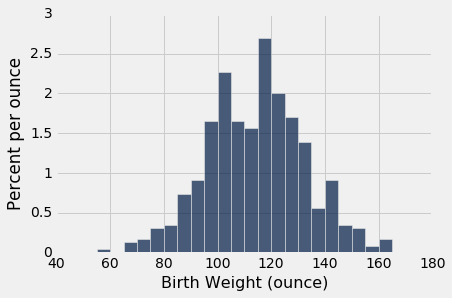

In [5]:
baby.where('Maternal Smoker', True).hist('Birth Weight', bins=np.arange(40, 181, 5), unit='ounce')

Both distributions are approximately bell shaped and centered near 120 ounces. The distributions are not identical, of course, which raises the question of whether the difference reflects just chance variation or a difference in the distributions in the population.

This question can be answered by a test of the null and alternative hypotheses below. Because we are testing for the equality of two distributions, one for Category A (mothers who don't smoke) and the other for Category B (mothers who smoke), the method is known rather unimaginatively as *A/B testing*.

**Null hypothesis.** In the population, the distribution of birth weights of babies is the same for mothers who don't smoke as for mothers who do. The difference in the sample is due to chance.

**Alternative hypothesis.** The two distributions are different in the population.

**Test statistic.** Birth weight is a quantitative variable, so it is reasonable to use the difference between means as the test statistic. There are other reasonable test statistics as well; the difference between means is just one simple choice.

The observed difference between the means of the two groups in the sample is about 9.27 ounces.

In [6]:
nonsmokers_mean = np.mean(baby.where('Maternal Smoker', False).column('Birth Weight'))
smokers_mean = np.mean(baby.where('Maternal Smoker', True).column('Birth Weight'))
nonsmokers_mean - smokers_mean

9.2661425720249184

### Implementing the bootstrap method

To see whether such a difference could have arisen due to chance under the null hypothesis, we could use a permutation test just as we did in the previous section. An alternative is to use the bootstrap, which we will do here.

Under the null hypothesis, the distributions of birth weights are the same for babies of women who smoke and for babies of those who don't. To see how much the distributions could vary due to chance alone, we will use the bootstrap method and draw new samples at random *with* replacement from the entire set of birth weights. The only difference between this and the permutation test of the previous section is that random permutations are based on sampling *without* replacement.

We will perform 10,000 repetitions of the bootstrap process. There are 1,174 babies, so in each repetition of the bootstrap process we drawn 1,174 times at random with replacement. Of these 1,174 draws, 715 are assigned to the non-smoking mothers and the remaining 459 to the mothers who smoke.

The code starts by sorting the rows so that the rows corresponding to the 715 non-smokers appear first. This eliminates the need to use conditional expressions to identify the rows corresponding to smokers and non-smokers in each replication of the sampling process.

Observed difference in means:  9.26614257202


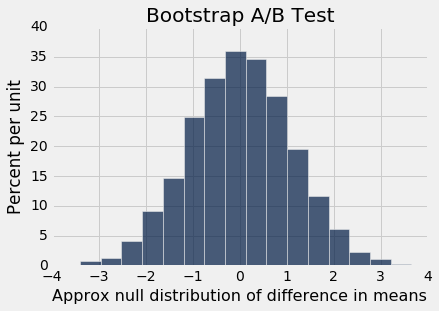

In [7]:
"""Bootstrap test for the difference in mean birthweight
Category A: non-smoker      Category B: smoker"""

sorted_by_smoking = baby.select(['Maternal Smoker', 'Birth Weight']).sort('Maternal Smoker')

# calculate the observed difference in means
meanA = np.mean(sorted_by_smoking.column('Birth Weight')[:715])
meanB = np.mean(sorted_by_smoking.column('Birth Weight')[715:])
observed_difference = meanA - meanB

repetitions=10000
diffs = []

for i in range(repetitions):
    
    # sample WITH replacement, same number as original sample size
    resample = sorted_by_smoking.sample(with_replacement=True)
    
    # Compute the difference of the means of the resampled values, between Categories A and B
    diff_means = np.mean(resample.column('Birth Weight')[:715]) - np.mean(resample.column('Birth Weight')[715:])
    diffs.append([diff_means])

# Display results   
differences = Table().with_column('diff_in_means', diffs)
differences.hist(bins=20)
plots.xlabel('Approx null distribution of difference in means')
plots.title('Bootstrap A/B Test')
plots.xlim(-4, 4)
plots.ylim(0, 0.4)
print('Observed difference in means: ', observed_difference)

The figure shows that under the null hypothesis of equal distributions in the population, the bootstrap empirical distribution of the difference between the sample means of the two groups is roughly bell shaped, centered at 0, stretching from about $-4$ ounces to $4$ ounces. The observed difference in the original sample is about 9.27 ounces, which is inconsistent with this distribution. So the conclusion of the test is that in the population, the distributions of birth weights of the babies of non-smokers and smokers are different.

### Bootstrap A/B testing
Let us define a function ``bootstrap_AB_test`` that performs an A/B test using the bootstrap method and the difference in sample means as the test statistic. The null hypothesis is that the two underlying distributions in the population are equal; the alternative is that they are not.

The arguments of the function are:

- the name of the table that contains the data in the original sample
- the label of the column containing the code 0 for Category A and 1 for Category B
- the label of the column containing the values of the response variable (that is, the variable whose distribution is of interest)
- the number of repetitions of the resampling procedure

The function returns the observed difference in means, the bootstrap empirical distribution of the difference in means, and the bootstrap empirical P-value. Because the alternative simply says that the two underlying distributions are different, the P-value is computed as the proportion of sampled differences that are at least as large in absolute value as the absolute value of the observed difference.

In [8]:
"""Bootstrap A/B test for the difference in the mean response
Assumes A=0, B=1"""

def bootstrap_AB_test(table, categories, values, repetitions):
    
    # Sort the sample table according to the A/B column; 
    # then select only the column of effects.
    response = table.sort(categories).select(values)
    
    # Find the number of entries in Category A.
    n_A = table.where(categories, 0).num_rows
      
    # Calculate the observed value of the test statistic.
    meanA = np.mean(response.column(values)[:n_A])
    meanB = np.mean(response.column(values)[n_A:])
    observed_difference = meanA - meanB
    
    # Run the bootstrap procedure and get a list of resampled differences in means
    diffs = []
    for i in range(repetitions):
        resample = response.sample(with_replacement=True)
        d = np.mean(resample.column(values)[:n_A]) - np.mean(resample.column(values)[n_A:])
        diffs.append([d])
    
    # Compute the bootstrap empirical P-value
    diff_array = np.array(diffs)
    empirical_p = np.count_nonzero(abs(diff_array) >= abs(observed_difference))/repetitions
    
    # Display results
    differences = Table().with_column('diff_in_means', diffs)
    differences.hist(bins=20,normed=True)
    plots.xlabel('Approx null distribution of difference in means')
    plots.title('Bootstrap A/B Test')
    print("Observed difference in means: ", observed_difference)
    print("Bootstrap empirical P-value: ", empirical_p)

We can now use the function ``bootstrap_AB_test`` to compare the smokers and non-smokers with respect to several different response variables. The tests show a statistically significant difference between the two groups in birth weight (as shown earlier), gestational days, maternal age, and maternal pregnancy weight. It comes as no surprise that the two groups do not differ significantly in their mean heights.

Observed difference in means:  9.26614257202
Bootstrap empirical P-value:  0.0


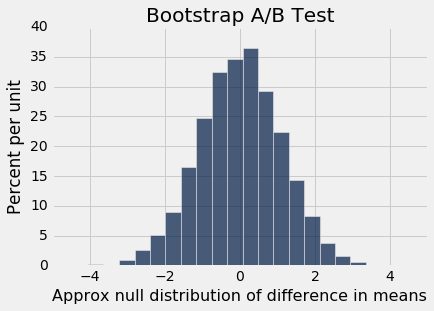

In [9]:
bootstrap_AB_test(baby, 'Maternal Smoker', 'Birth Weight', 10000)

Observed difference in means:  1.97652238829
Bootstrap empirical P-value:  0.0367


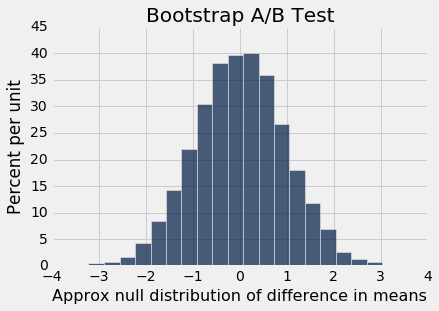

In [10]:
bootstrap_AB_test(baby, 'Maternal Smoker', 'Gestational Days', 10000)

Observed difference in means:  0.80767250179
Bootstrap empirical P-value:  0.0192


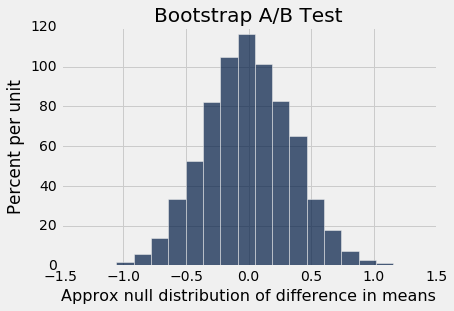

In [11]:
bootstrap_AB_test(baby, 'Maternal Smoker', 'Maternal Age', 10000)

Observed difference in means:  2.56033030151
Bootstrap empirical P-value:  0.0374


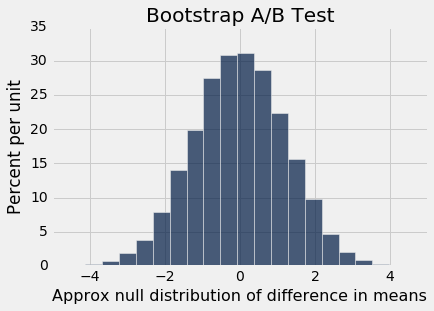

In [12]:
bootstrap_AB_test(baby, 'Maternal Smoker', 'Maternal Pregnancy Weight', 10000)

Observed difference in means:  -0.0905891494127
Bootstrap empirical P-value:  0.5411


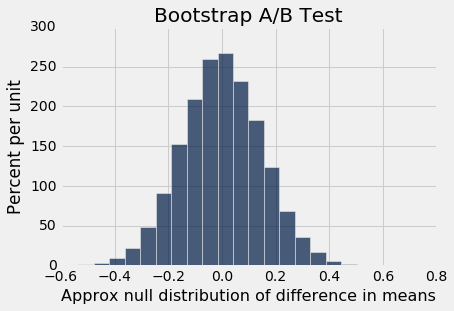

In [13]:
bootstrap_AB_test(baby, 'Maternal Smoker', 'Maternal Height', 10000)